<a href="https://colab.research.google.com/github/gyanendar/ms_project/blob/main/GoogLeNet_BaseLine2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import random
from tabnanny import verbose
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import argparse
from tensorflow.keras import callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn import metrics
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import tensorflow.keras.backend as K
from tensorflow.keras import initializers, layers
from sklearn.metrics import confusion_matrix,accuracy_score
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
RIM_ONE_DL_DIR = '/content/gdrive/My Drive/MSC_Project/Dataset/RIM-ONE_DL_images/partitioned_randomly'
RIM_ONE_R2_DIR= '/content/gdrive/My Drive/MSC_Project/Dataset/RIMONE-db-r2'
ACRIMA_DIR = '/content/gdrive/My Drive/MSC_Project/Dataset/ACRIMA'
DRISHTI_GS1 = '/content/gdrive/My Drive/MSC_Project/Dataset/Drishti-GS1'
SAVE_FILE_PERFORMANCE_TRAINED = r'/content/gdrive/My Drive/MSC_Project/Model/CNN/generated_data/baseline_2.csv'

In [ ]:
def initialise_df_perfromance_matrix():
  g_performance_df =  pd.DataFrame([], columns = ['Model', 'Accuracy','Precision','Recall','F1','AUC','Sensitivity','Specificity','kappa'])
  g_performance_df.to_csv(SAVE_FILE_PERFORMANCE_TRAINED, encoding='utf-8', index=False)

In [ ]:
initialise_df_perfromance_matrix()

In [ ]:
def save_performance_data(new_data):
  g_performance_df = pd.read_csv(SAVE_FILE_PERFORMANCE_TRAINED)
  data_list = g_performance_df.values.tolist()
  data_exist = False
  for index in range(len(data_list)):
    if(data_list[index][0]==new_data[0]):
      data_list[index] = new_data
      data_exist = True
  if(data_exist==False):
    data_list.append(new_data)
  g_performance_df = pd.DataFrame(data_list, columns = ['Model', 'Accuracy','Precision','Recall','F1','AUC','Sensitivity','Specificity','kappa'])
  g_performance_df.to_csv(SAVE_FILE_PERFORMANCE_TRAINED, encoding='utf-8', index=False)

In [ ]:
def plot_performance():
  g_performance_df = pd.read_csv(SAVE_FILE_PERFORMANCE_TRAINED)
  display(g_performance_df)
  plt.figure()
  plot = sns.barplot(y='Model', x='Accuracy', data=g_performance_df)
  plt.show()

  print(g_performance_df.to_latex(index=False))

In [ ]:

BATCH_SIZE = 32
CLASS_COUNT = 2
NUM_EPOCHS_A = 25
NUM_EPOCHS_B = 25
g_performance = {}

In [ ]:
# Resize image to 256*256
# Convert to numpy array
def process_image(data_set_dir, label_dict, width, height):
    
    x = [] # will store images as arrays
    y = [] # store labels
    # list folders in directory
    directories = os.listdir(data_set_dir)
     
    # for each folder (train and validation) 
    for label in directories:
        
        # add class label to label dictionary
        if label not in label_dict:
            label_dict[label] = len(label_dict)
        
        # create full path for image directory 
        source_images = os.path.join(data_set_dir, label)
        images = os.listdir(source_images)
        # for each image in directory, 
        for image in images:
            #folder have .txt files which needs to be ignored
            if '.txt'not in image:
                # read the image from file, resize and add to a list
                full_size_image = cv2.imread(os.path.join(source_images, image))
                
                #append the image to x
                x.append(cv2.resize(full_size_image, (width,height), 
                                                            interpolation=cv2.INTER_CUBIC))
                # add the class label to y
                y.append(label)

   
    data = np.array(x, dtype="float") / 255.0                
    label = np.array(y)
    
    return data,label

In [ ]:
def set_seed():
  tf.random.set_seed(100)
  np.random.seed(100)
  random.seed(100)

In [ ]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

def get_early_stoping_cb_on_min_val_loss(patience_num = 10):
  return EarlyStopping(monitor='val_loss', mode='min', verbose=0, \
                       patience=patience_num)

def get_model_checkpoint_cb_on_max_val_acc(file_name):
  return ModelCheckpoint(file_name, monitor="val_accuracy", 	mode="max", \
                         save_best_only=True, verbose=1)	

def learning_rate_schedular_fun(epoch, lr):
  if epoch <10:
    return lr 
  else:
    #return lr*tf.math.exp(-.1)
    return lr*0.1
  
def get_model_learning_rate_cb():
  return tf.keras.callbacks.LearningRateScheduler(learning_rate_schedular_fun,\
                                                  verbose=0)


def get_basic_callback():
  return [get_early_stoping_cb_on_min_val_loss()]

def get_basic_and_lrs_callback():
  return [get_early_stoping_cb_on_min_val_loss(),get_model_learning_rate_cb()]

def get_all_callback(file_name):
  return [get_early_stoping_cb_on_min_val_loss(),\
          get_model_learning_rate_cb(),\
          get_model_checkpoint_cb_on_max_val_acc(file_name)]

In [ ]:
# Returns Pretrained Network with top layer removed
# And Trainable set to false

def get_high_level_model(trained_model_name,inputshape):
  set_seed()
  model = None
  if trained_model_name == "vgg16":
      model = tf.keras.applications.VGG16(weights='imagenet', \
                              include_top = False, input_shape = inputshape)
      
  elif trained_model_name == "vgg19":
      model =  tf.keras.applications.VGG19(weights='imagenet', \
                              include_top = False, input_shape = inputshape)
      
  elif trained_model_name == "resnet50":
     model = tf.keras.applications.ResNet50(weights='imagenet', \
                              include_top = False, input_shape = inputshape)
     
  elif trained_model_name == "xception":
     model = tf.keras.applications.Xception(weights='imagenet', \
                            include_top = False, input_shape = inputshape)
     
  elif trained_model_name == "DenseNet121":
     model = tf.keras.applications.DenseNet121(weights='imagenet', \
                            include_top = False, input_shape = inputshape)
  elif trained_model_name == "MobileNet":
     model = tf.keras.applications.MobileNet(weights='imagenet', \
                            include_top = False, input_shape = inputshape)
  elif trained_model_name == "MobileNetV2":
     model = tf.keras.applications.MobileNetV2(weights='imagenet', \
                            include_top = False, input_shape = inputshape)
  elif trained_model_name == "InceptionResNetV2":
     model = tf.keras.applications.InceptionResNetV2(weights='imagenet', \
                            include_top = False, input_shape = inputshape)
  elif trained_model_name == "InceptionV3":
     model = tf.keras.applications.InceptionV3(weights='imagenet', \
                            include_top = False, input_shape = inputshape)  
  elif trained_model_name == "NASNetMobile":
     model = tf.keras.applications.NASNetMobile(weights='imagenet', \
                            include_top = False, input_shape = inputshape)

  elif trained_model_name == "NASNetLarge":
     model = tf.keras.applications.NASNetMobile(weights='imagenet', \
                            include_top = False, input_shape = inputshape)         
  
  if model != None:
    model.trainable = False

  return model

In [ ]:
def plot_model_performance(history,model_name,part):
  plt.style.use("ggplot")
  plt.figure(figsize=(7,6))
  epoch_ran = len(history.history["loss"])
  plt.plot(np.arange(0, epoch_ran), \
           history.history["loss"], label="train_loss")
  plt.plot(np.arange(0, epoch_ran), \
           history.history["val_loss"], label="val_loss")
  plt.plot(np.arange(0, epoch_ran), \
           history.history["accuracy"], label="train_acc")
  plt.plot(np.arange(0, epoch_ran), \
           history.history["val_accuracy"], label="val_acc")
  plt.title("Training Loss and Accuracy")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss/Accuracy")
  plt.legend()
  plt.show()

  #Print best score 
 
  print("\nModel Performance Summary:\n")
  
  

  epoch_index = history.history["val_accuracy"].index(max(history.history["val_accuracy"]))
    
  best_val_accuracy = history.history["val_accuracy"][epoch_index]

  print(f"Best Validation accuracy:{best_val_accuracy} at EPOCH:{epoch_index+1}")

In [ ]:
import gc

class HIGH_LEVEL_MODEL:
  def __init__(self, trained_model_name,fold = 5, inputshape = (224,224,3)):

    set_seed()
    
    #Start constructing the model with pretrained network 
    self.model = tf.keras.models.Sequential(name = trained_model_name)
    
    # Get Pretrained model with top layer removed and trainable parameter frozen
    self.high_level_model_obj = get_high_level_model(trained_model_name, \
                                                     inputshape)
    self.model.add(self.high_level_model_obj)
    
    # Flatten the output and add FC & Softmax layer
    self.model.add(tf.keras.layers.Flatten())
    #self.model.add(tf.keras.layers.GlobalAveragePooling2D())
    
    #self.model.add(tf.keras.layers.Dense(512, activation='relu'))  
    self.model.add(tf.keras.layers.Dense(CLASS_COUNT, activation='softmax'))                             
    
    #Model is constructed Now
    print(self.model.summary())    
    
    #display(plot_model(self.model, show_shapes=True, expand_nested=True))
    
    # Setting Model JSON file and weight filte name 
    self.model_file_name = self.model.name+".json"
    self.fold_count = fold
    #display(plot_model(self.model, show_shapes=True, expand_nested=True))
    #self.kfold = KFold(n_splits=self.fold_count, shuffle=True)
    # Setting Model JSON file and weight filte name 
    self.model_file_name = self.model.name+".json"
    #for index in range(0,fold):
    self.model_wt_file_name_a = f"{self.model.name}_a.hdf5"
    self.model_wt_file_name_b = f"{self.model.name}_b.hdf5"
    self.model_wt_file_name = f"{self.model.name}_wt.hdf5"
    
    # To identify the variantion in parameter 
    #self.model_varient = varient

  def train_phase(self,train_x,train_y,test_x,test_y,model_name,data_aug = False):
    
    train_data_generator = ImageDataGenerator()
    if data_aug == True:
      train_data_generator = ImageDataGenerator(horizontal_flip=True,vertical_flip=True,rotation_range=30, fill_mode='nearest',zoom_range=0.2)
    
    train_generator = train_data_generator.flow(train_x, train_y, batch_size=BATCH_SIZE)
   
    val_data_generator = ImageDataGenerator()
    val_generator = val_data_generator.flow(test_x, test_y, batch_size=BATCH_SIZE)

    self.model.compile(loss='categorical_crossentropy', \
          optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),metrics=['accuracy'])
    
    model_json = self.model.to_json()
    with open(self.model_file_name, "w") as json_file:
      json_file.write(model_json)

    history = self.model.fit(train_generator, epochs=NUM_EPOCHS_A, \
                   batch_size=BATCH_SIZE, validation_data=val_generator, \
                   callbacks = get_all_callback(self.model_wt_file_name_a),verbose=0)        
    best_val_accuracy = max(history.history["val_accuracy"])
    #self.fold_accuracy_a.append(best_val_accuracy)
      
    plot_model_performance(history,self.model.name,"phase_a")

    #self.model.load_weights(self.model_wt_file_name_a)
    #self.high_level_model_obj.trainable = True

    #optimizer_obj = tf.keras.optimizers.RMSprop(learning_rate=0.0001)
    #self.model.compile(loss='categorical_crossentropy',
    #            optimizer=optimizer_obj,
    #            metrics=['accuracy'])
    
    #history = self.model.fit(train_generator, epochs=NUM_EPOCHS_B, \
    #               batch_size=BATCH_SIZE, validation_data=val_generator, \
    #               callbacks = get_all_callback(self.model_wt_file_name_b))

    #plot_model_performance(history,self.model.name,"phase_b")
    #gc.collect()

    
    self.model.load_weights(self.model_wt_file_name_a)
    
    predicted_val = self.model.predict(test_x,verbose = 1)
    self.y_classes = predicted_val.argmax(axis=-1)
    actual_val = test_y.argmax(axis=-1)

    tn, fp, fn, tp = confusion_matrix(actual_val, self.y_classes).ravel()
    final_accuracy = accuracy_score(actual_val, self.y_classes)
    final_sensitivity=tp/(tp+fn)
    print("Accuracy:",final_accuracy)
    print("Sensitivity:",final_sensitivity)
    specificity = tn/(tn+fp)
    kappa = cohen_kappa_score(actual_val, self.y_classes)
    #self.fpr, self.tpr, _ = roc_curve(test_y, self.y_classes)
    #self.roc_auc = auc(self.fpr, self.tpr)
    #plot_ROC_AUC(self.fpr, self.tpr, self.roc_auc)     
    
    fpr, tpr, thresholds = metrics.roc_curve(actual_val, self.y_classes)
    auc = metrics.auc(fpr, tpr)
    print(f"AUC:{auc}")
    precision = precision_score(actual_val, self.y_classes)
    recall = recall_score(actual_val, self.y_classes)
    f1 = f1_score(actual_val, self.y_classes)

   
    model_performance = [(model_name,final_accuracy,precision,recall,f1,auc,final_sensitivity,specificity,kappa)]
    df = pd.DataFrame(model_performance, columns = ['Model', 'Accuracy','Precision','Recall','F1','AUC','Sensitivity','Specificity','Kappa'])
    display(df)
    save_performance_data([model_name,final_accuracy,precision,recall,f1,auc,final_sensitivity,specificity,kappa])
    #save_performance_data([self.model.name,final_accuracy,final_sensitivity,auc])
    
 
  def get_scores(self,test_x,test_y):

    #index= self.fold_accuracy_b.index(max(self.fold_accuracy_b))
    #self.model.load_weights(self.model_wt_file_name_b[index])
    self.model.load_weights(self.model_wt_file_name)
    optimizer_obj = tf.keras.optimizers.RMSprop(learning_rate=1e-5)
    self.model.compile(loss='sparse_categorical_crossentropy',
                optimizer=optimizer_obj,
                metrics=['accuracy'])
    
    predicted_val = self.model.predict(test_x,verbose = 1)
    self.y_classes = predicted_val.argmax(axis=-1)
    tn, fp, fn, tp = confusion_matrix(test_y, self.y_classes).ravel()
    print("Accuracy:",accuracy_score(test_y, self.y_classes))
    print("Sensitivity:",tp/(tp+fn))
    
    #self.fpr, self.tpr, _ = roc_curve(test_y, self.y_classes)
    #self.roc_auc = auc(self.fpr, self.tpr)
    #plot_ROC_AUC(self.fpr, self.tpr, self.roc_auc)  

In [ ]:
def get_rim_one_db_r2(width,height,test_train_ratio = 0.2,histogram_eq = False):
  print(f"Height:{height} Width:{width}")
  class_labels = {}
  training_images,training_labels = process_image(RIM_ONE_R2_DIR,
                                                  class_labels,
                                                  width,height)
  
  training_label = (pd.Series(training_labels).map(class_labels)).values
  training_label = to_categorical(training_label.astype('float32'))
  training_images = training_images.reshape(-1, width, width, 3).astype('float32')

  X_train, X_test, y_train, y_test = train_test_split(training_images, 
                                                      training_label, 
                                                      test_size=test_train_ratio, 
                                                      random_state=100)

  return (X_train,y_train),(X_test,y_test)

In [ ]:
def get_rim_one_dl(width,height,histogram_eq = False):
  class_labels = {}
  training_images,training_labels = process_image(RIM_ONE_DL_DIR+"/training_set",
                                                  class_labels,
                                                  width,height)
  
  training_label = (pd.Series(training_labels).map(class_labels)).values
  training_label = to_categorical(training_label.astype('float32'))
  training_images = training_images.reshape(-1, width, height, 3).astype('float32')

  test_images,test_labels = process_image(RIM_ONE_DL_DIR+"/test_set",
                                          class_labels,
                                          width,height)
  
  test_label = (pd.Series(test_labels).map(class_labels)).values
  test_label = to_categorical(test_label.astype('float32'))
  test_images = test_images.reshape(-1, width, height, 3).astype('float32')

  return (training_images,training_label),(test_images,test_label)

In [ ]:
def get_acrima_dataset(width,height,test_train_ratio = 0.2):
  print(f"Height:{height} Width:{width}")
  class_labels = {}
  training_images,training_labels = process_image(ACRIMA_DIR,
                                                  class_labels,
                                                  width,height)
  
  training_label = (pd.Series(training_labels).map(class_labels)).values
  training_label = to_categorical(training_label.astype('float32'))
  training_images = training_images.reshape(-1, width, width, 3).astype('float32')

  X_train, X_test, y_train, y_test = train_test_split(training_images, 
                                                      training_label, 
                                                      test_size=test_train_ratio, 
                                                      random_state=100)

  return (X_train,y_train),(X_test,y_test)

In [ ]:
(trainx,trainy),(testx,testy) = get_rim_one_db_r2(width = 256,height = 256,test_train_ratio = 0.2)

Height:256 Width:256


Height:299 Width:299
87924736/87910968 [==============================] - 1s 0us/step
Model: "InceptionV3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 2)                 262146    
                                                                 
Total params: 22,064,930
Trainable params: 262,146
Non-trainable params: 21,802,784
_________________________________________________________________
None

Epoch 1: val_accuracy improved from -inf to 0.69565, saving model to InceptionV3_a.hdf5

Epoch 2: val_accuracy improved from 0.69565 to 0.76087, saving model to InceptionV3_a.hdf5

Epoch 3: val_accuracy did no

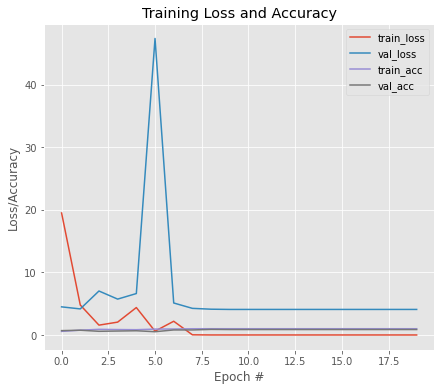


Model Performance Summary:

Best Validation accuracy:0.8913043737411499 at EPOCH:9
2/2 [==============================] - 1s 64ms/step
Accuracy: 0.8913043478260869
Sensitivity: 0.9090909090909091
AUC:0.8920454545454545


,Model,Accuracy,Precision,Recall,F1,AUC,Sensitivity,Specificity,Kappa
0,"RIM-ONE_v2_A_False_[0.1, 0.2]_InceptionV3",0.891304,0.869565,0.909091,0.888889,0.892045,0.909091,0.875,0.782609


Model: "InceptionV3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 flatten_1 (Flatten)         (None, 131072)            0         
                                                                 
 dense_1 (Dense)             (None, 2)                 262146    
                                                                 
Total params: 22,064,930
Trainable params: 262,146
Non-trainable params: 21,802,784
_________________________________________________________________
None

Epoch 1: val_accuracy improved from -inf to 0.54348, saving model to InceptionV3_a.hdf5

Epoch 2: val_accuracy improved from 0.54348 to 0.73913, saving model to InceptionV3_a.hdf5

Epoch 3: val_accuracy did not improve from 0.73913

Epoch 4: val_accuracy did not improve from 0.73913

Epoch 5: v

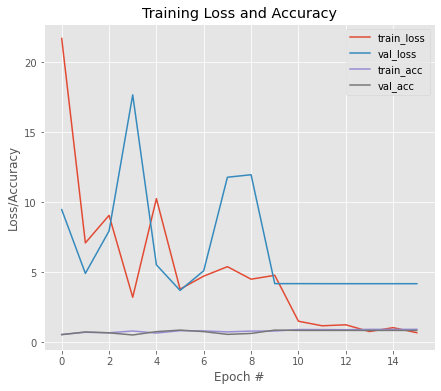


Model Performance Summary:

Best Validation accuracy:0.8695651888847351 at EPOCH:6
2/2 [==============================] - 2s 67ms/step
Accuracy: 0.8695652173913043
Sensitivity: 0.8636363636363636
AUC:0.8693181818181819


,Model,Accuracy,Precision,Recall,F1,AUC,Sensitivity,Specificity,Kappa
0,"RIM-ONE_v2_A_True_[0.1, 0.2]_InceptionV3",0.869565,0.863636,0.863636,0.863636,0.869318,0.863636,0.875,0.738636


Height:299 Width:299
Model: "InceptionV3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 flatten_2 (Flatten)         (None, 131072)            0         
                                                                 
 dense_2 (Dense)             (None, 2)                 262146    
                                                                 
Total params: 22,064,930
Trainable params: 262,146
Non-trainable params: 21,802,784
_________________________________________________________________
None

Epoch 1: val_accuracy improved from -inf to 0.54945, saving model to InceptionV3_a.hdf5

Epoch 2: val_accuracy improved from 0.54945 to 0.86813, saving model to InceptionV3_a.hdf5

Epoch 3: val_accuracy did not improve from 0.86813

Epoch 4: val_accuracy did not improve fro

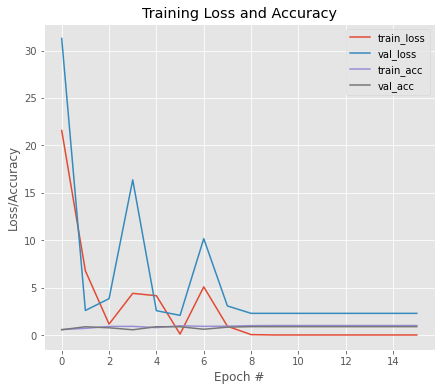


Model Performance Summary:

Best Validation accuracy:0.8791208863258362 at EPOCH:9
3/3 [==============================] - 2s 68ms/step
Accuracy: 0.8791208791208791
Sensitivity: 0.8536585365853658
AUC:0.8768292682926829


,Model,Accuracy,Precision,Recall,F1,AUC,Sensitivity,Specificity,Kappa
0,"RIM-ONE_v2_A_False_[0.1, 0.2]_InceptionV3",0.879121,0.875,0.853659,0.864198,0.876829,0.853659,0.9,0.755317


Model: "InceptionV3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 flatten_3 (Flatten)         (None, 131072)            0         
                                                                 
 dense_3 (Dense)             (None, 2)                 262146    
                                                                 
Total params: 22,064,930
Trainable params: 262,146
Non-trainable params: 21,802,784
_________________________________________________________________
None

Epoch 1: val_accuracy improved from -inf to 0.80220, saving model to InceptionV3_a.hdf5

Epoch 2: val_accuracy did not improve from 0.80220

Epoch 3: val_accuracy did not improve from 0.80220

Epoch 4: val_accuracy did not improve from 0.80220

Epoch 5: val_accuracy improved from 0.80220 to 0.8

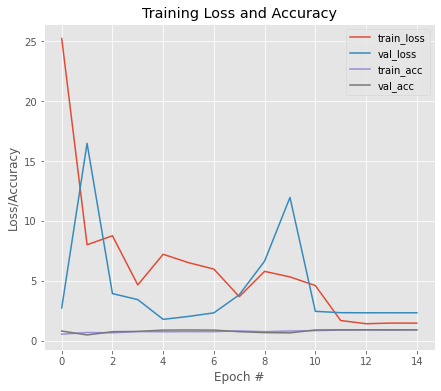


Model Performance Summary:

Best Validation accuracy:0.901098906993866 at EPOCH:12
3/3 [==============================] - 1s 69ms/step
Accuracy: 0.9010989010989011
Sensitivity: 0.8536585365853658
AUC:0.8968292682926828


,Model,Accuracy,Precision,Recall,F1,AUC,Sensitivity,Specificity,Kappa
0,"RIM-ONE_v2_A_True_[0.1, 0.2]_InceptionV3",0.901099,0.921053,0.853659,0.886076,0.896829,0.853659,0.94,0.79892


In [ ]:
split_ratio = [0.1,0.2]
data_aug = [False,True]

for ratio in split_ratio:
  (trainx,trainy),(testx,testy) = get_rim_one_db_r2(width = 299,height = 299,test_train_ratio = ratio)
  for aug in data_aug:
    model_obj = HIGH_LEVEL_MODEL("InceptionV3",inputshape=(299,299,3))
    name = f"RIM-ONE_v2_A_{aug}_{split_ratio}_InceptionV3"
    model_obj.train_phase(trainx,trainy,testx,testy,data_aug=aug,model_name = name)



,Model,Accuracy,Precision,Recall,F1,AUC,Sensitivity,Specificity,kappa
0,InceptionV3_A_False_0.1,0.869565,0.900000,0.818182,0.857143,0.867424,0.818182,0.916667,0.737643
1,InceptionV3_A_True_0.1,0.913043,0.875000,0.954545,0.913043,0.914773,0.954545,0.875000,0.826415
2,InceptionV3_A_False_0.2,0.868132,0.853659,0.853659,0.853659,0.866829,0.853659,0.880000,0.733659
3,InceptionV3_A_True_0.2,0.890110,0.844444,0.926829,0.883721,0.893415,0.926829,0.860000,0.779981


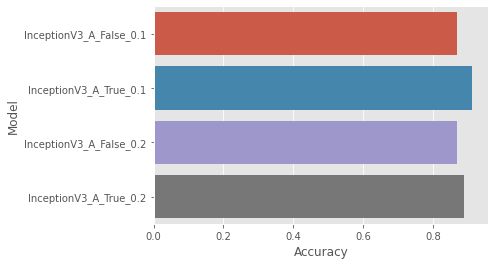

\begin{tabular}{lrrrrrrrr}
\toprule
                  Model &  Accuracy &  Precision &   Recall &       F1 &      AUC &  Sensitivity &  Specificity &    kappa \\
\midrule
InceptionV3\_A\_False\_0.1 &  0.869565 &   0.900000 & 0.818182 & 0.857143 & 0.867424 &     0.818182 &     0.916667 & 0.737643 \\
 InceptionV3\_A\_True\_0.1 &  0.913043 &   0.875000 & 0.954545 & 0.913043 & 0.914773 &     0.954545 &     0.875000 & 0.826415 \\
InceptionV3\_A\_False\_0.2 &  0.868132 &   0.853659 & 0.853659 & 0.853659 & 0.866829 &     0.853659 &     0.880000 & 0.733659 \\
 InceptionV3\_A\_True\_0.2 &  0.890110 &   0.844444 & 0.926829 & 0.883721 & 0.893415 &     0.926829 &     0.860000 & 0.779981 \\
\bottomrule
\end{tabular}



In [ ]:
plot_performance()

,Model,Accuracy,Precision,Recall,F1,AUC,Sensitivity,Specificity,kappa
0,RIM-ONE_v2_A_False_0.2_vgg16,0.835165,0.842105,0.780488,0.810127,0.830244,0.780488,0.88,0.664866
1,RIM-ONE_v2_A_True_0.2_vgg16,0.780220,0.818182,0.658537,0.729730,0.769268,0.658537,0.88,0.548163
2,RIM-ONE_v2_A_False_0.2_vgg19,0.802198,0.828571,0.707317,0.763158,0.793659,0.707317,0.88,0.595156
3,RIM-ONE_v2_A_True_0.2_vgg19,0.780220,0.818182,0.658537,0.729730,0.769268,0.658537,0.88,0.548163
4,RIM-ONE_v2_A_False_0.2_resnet50,0.681319,0.928571,0.317073,0.472727,0.648537,0.317073,0.98,0.315789
5,RIM-ONE_v2_A_True_0.2_resnet50,0.604396,1.000000,0.121951,0.217391,0.560976,0.121951,1.00,0.132415
6,RIM-ONE_v2_A_False_0.2_DenseNet121,0.890110,0.844444,0.926829,0.883721,0.893415,0.926829,0.86,0.779981
7,RIM-ONE_v2_A_True_0.2_DenseNet121,0.868132,0.853659,0.853659,0.853659,0.866829,0.853659,0.88,0.733659
8,RIM-ONE_v2_A_False_0.2_MobileNet,0.890110,0.942857,0.804878,0.868421,0.882439,0.804878,0.96,0.775087
9,RIM-ONE_v2_A_True_0.2_MobileNet,0.890110,0.942857,0.804878,0.868421,0.882439,0.804878,0.96,0.775087


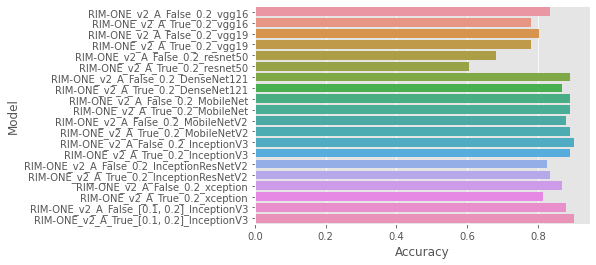

\begin{tabular}{lrrrrrrrr}
\toprule
                                    Model &  Accuracy &  Precision &   Recall &       F1 &      AUC &  Sensitivity &  Specificity &    kappa \\
\midrule
             RIM-ONE\_v2\_A\_False\_0.2\_vgg16 &  0.835165 &   0.842105 & 0.780488 & 0.810127 & 0.830244 &     0.780488 &         0.88 & 0.664866 \\
              RIM-ONE\_v2\_A\_True\_0.2\_vgg16 &  0.780220 &   0.818182 & 0.658537 & 0.729730 & 0.769268 &     0.658537 &         0.88 & 0.548163 \\
             RIM-ONE\_v2\_A\_False\_0.2\_vgg19 &  0.802198 &   0.828571 & 0.707317 & 0.763158 & 0.793659 &     0.707317 &         0.88 & 0.595156 \\
              RIM-ONE\_v2\_A\_True\_0.2\_vgg19 &  0.780220 &   0.818182 & 0.658537 & 0.729730 & 0.769268 &     0.658537 &         0.88 & 0.548163 \\
          RIM-ONE\_v2\_A\_False\_0.2\_resnet50 &  0.681319 &   0.928571 & 0.317073 & 0.472727 & 0.648537 &     0.317073 &         0.98 & 0.315789 \\
           RIM-ONE\_v2\_A\_True\_0.2\_resnet50 &  0.604396 &   1.0

In [ ]:
plot_performance()

Model: "InceptionV3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 flatten_6 (Flatten)         (None, 73728)             0         
                                                                 
 dense_6 (Dense)             (None, 2)                 147458    
                                                                 
Total params: 21,950,242
Trainable params: 147,458
Non-trainable params: 21,802,784
_________________________________________________________________
None

Epoch 1: val_accuracy improved from -inf to 0.64384, saving model to InceptionV3_a.hdf5

Epoch 2: val_accuracy improved from 0.64384 to 0.78767, saving model to InceptionV3_a.hdf5

Epoch 3: val_accuracy did not improve from 0.78767

Epoch 4: val_accuracy did not improve from 0.78767

Epoch 5: v

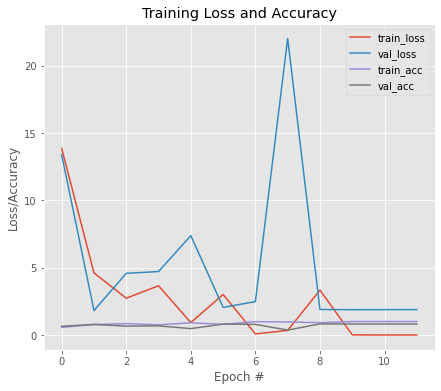


Model Performance Summary:

Best Validation accuracy:0.8219178318977356 at EPOCH:9
5/5 [==============================] - 2s 53ms/step
Accuracy: 0.821917808219178
Sensitivity: 0.8617021276595744
AUC:0.8058510638297872


,Model,Accuracy,Precision,Recall,F1,AUC,Sensitivity,Specificity,Kappa
0,InceptionV3_A_False_0.2,0.821918,0.861702,0.861702,0.861702,0.805851,0.861702,0.75,0.611702


Model: "InceptionV3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 flatten_7 (Flatten)         (None, 73728)             0         
                                                                 
 dense_7 (Dense)             (None, 2)                 147458    
                                                                 
Total params: 21,950,242
Trainable params: 147,458
Non-trainable params: 21,802,784
_________________________________________________________________
None

Epoch 1: val_accuracy improved from -inf to 0.64384, saving model to InceptionV3_a.hdf5

Epoch 2: val_accuracy improved from 0.64384 to 0.74658, saving model to InceptionV3_a.hdf5

Epoch 3: val_accuracy did not improve from 0.74658

Epoch 4: val_accuracy did not improve from 0.74658

Epoch 5: v

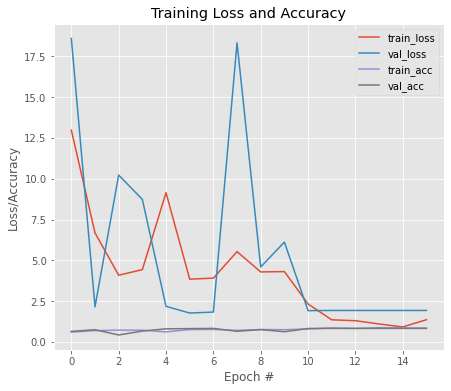


Model Performance Summary:

Best Validation accuracy:0.8287671208381653 at EPOCH:7
5/5 [==============================] - 2s 53ms/step
Accuracy: 0.8287671232876712
Sensitivity: 0.925531914893617
AUC:0.7896890343698855


,Model,Accuracy,Precision,Recall,F1,AUC,Sensitivity,Specificity,Kappa
0,InceptionV3_A_True_0.2,0.828767,0.828571,0.925532,0.874372,0.789689,0.925532,0.653846,0.608117


In [ ]:

data_aug = [False,True]
split_ratio = [0.2]
for ratio in split_ratio:
  (trainx,trainy),(testx,testy) = get_rim_one_dl(width = 256,height = 256)
  for aug in data_aug:
    model_obj = HIGH_LEVEL_MODEL("InceptionV3",inputshape=(256,256,3))
    name = f"RIM-ONE_v2_A_{aug}_{model}"
    model_obj.train_phase(trainx,trainy,testx,testy,data_aug=aug,test_train_ratio = ratio)

,Model,Accuracy,Precision,Recall,F1,AUC,Sensitivity,Specificity,kappa
0,InceptionV3_A_False_0.1,0.869565,0.900000,0.818182,0.857143,0.867424,0.818182,0.916667,0.737643
1,InceptionV3_A_True_0.1,0.913043,0.875000,0.954545,0.913043,0.914773,0.954545,0.875000,0.826415
2,InceptionV3_A_False_0.2,0.821918,0.861702,0.861702,0.861702,0.805851,0.861702,0.750000,0.611702
3,InceptionV3_A_True_0.2,0.828767,0.828571,0.925532,0.874372,0.789689,0.925532,0.653846,0.608117


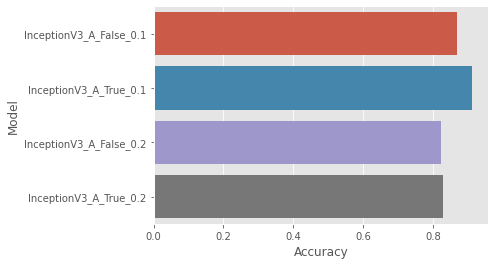

\begin{tabular}{lrrrrrrrr}
\toprule
                  Model &  Accuracy &  Precision &   Recall &       F1 &      AUC &  Sensitivity &  Specificity &    kappa \\
\midrule
InceptionV3\_A\_False\_0.1 &  0.869565 &   0.900000 & 0.818182 & 0.857143 & 0.867424 &     0.818182 &     0.916667 & 0.737643 \\
 InceptionV3\_A\_True\_0.1 &  0.913043 &   0.875000 & 0.954545 & 0.913043 & 0.914773 &     0.954545 &     0.875000 & 0.826415 \\
InceptionV3\_A\_False\_0.2 &  0.821918 &   0.861702 & 0.861702 & 0.861702 & 0.805851 &     0.861702 &     0.750000 & 0.611702 \\
 InceptionV3\_A\_True\_0.2 &  0.828767 &   0.828571 & 0.925532 & 0.874372 & 0.789689 &     0.925532 &     0.653846 & 0.608117 \\
\bottomrule
\end{tabular}



In [ ]:
plot_performance()

Height:256 Width:256
Model: "InceptionV3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 flatten_2 (Flatten)         (None, 73728)             0         
                                                                 
 dense_2 (Dense)             (None, 2)                 147458    
                                                                 
Total params: 21,950,242
Trainable params: 147,458
Non-trainable params: 21,802,784
_________________________________________________________________
None

Epoch 1: val_accuracy improved from -inf to 0.42553, saving model to InceptionV3_a.hdf5

Epoch 2: val_accuracy improved from 0.42553 to 0.66667, saving model to InceptionV3_a.hdf5

Epoch 3: val_accuracy improved from 0.66667 to 0.72340, saving model to InceptionV3_a.hdf5

E

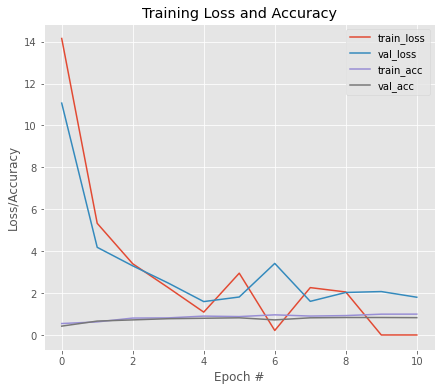


Model Performance Summary:

Best Validation accuracy:0.8368794322013855 at EPOCH:9
5/5 [==============================] - 2s 53ms/step
Accuracy: 0.8368794326241135
Sensitivity: 0.9137931034482759
AUC:0.8484628167843788


,Model,Accuracy,Precision,Recall,F1,AUC,Sensitivity,Specificity,Kappa
0,InceptionV3_A_False_0.2,0.836879,0.746479,0.913793,0.821705,0.848463,0.913793,0.783133,0.674169


Model: "InceptionV3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 flatten_3 (Flatten)         (None, 73728)             0         
                                                                 
 dense_3 (Dense)             (None, 2)                 147458    
                                                                 
Total params: 21,950,242
Trainable params: 147,458
Non-trainable params: 21,802,784
_________________________________________________________________
None

Epoch 1: val_accuracy improved from -inf to 0.43972, saving model to InceptionV3_a.hdf5

Epoch 2: val_accuracy improved from 0.43972 to 0.70922, saving model to InceptionV3_a.hdf5

Epoch 3: val_accuracy did not improve from 0.70922

Epoch 4: val_accuracy did not improve from 0.70922

Epoch 5: v

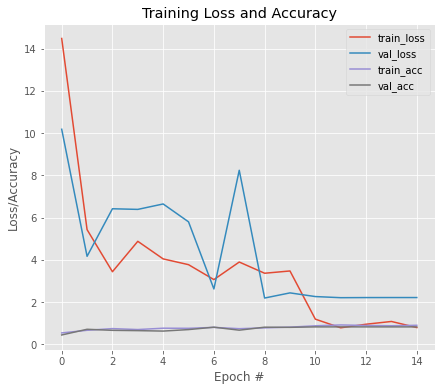


Model Performance Summary:

Best Validation accuracy:0.8226950168609619 at EPOCH:11
5/5 [==============================] - 2s 54ms/step
Accuracy: 0.8226950354609929
Sensitivity: 0.8448275862068966
AUC:0.8260282509347736


,Model,Accuracy,Precision,Recall,F1,AUC,Sensitivity,Specificity,Kappa
0,InceptionV3_A_True_0.2,0.822695,0.753846,0.844828,0.796748,0.826028,0.844828,0.807229,0.640416


In [ ]:
data_aug = [False,True]
split_ratio = [0.2]
for ratio in split_ratio:
  (trainx,trainy),(testx,testy) = get_acrima_dataset(width = 256,height = 256)
  for aug in data_aug:
    model_obj = HIGH_LEVEL_MODEL("InceptionV3",inputshape=(256,256,3))
    model_obj.train_phase(trainx,trainy,testx,testy,data_aug=aug,test_train_ratio = ratio)

# Model Performance

In [ ]:
MODEL_LIST = ['vgg16','vgg19','resnet50','DenseNet121','MobileNet','MobileNetV2','InceptionV3','InceptionResNetV2','xception']

In [ ]:
(trainx,trainy),(testx,testy) = get_rim_one_db_r2(width = 256,height = 256,test_train_ratio = 0.2)

Height:256 Width:256


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 32768)             0         
                                                                 
 dense_2 (Dense)             (None, 2)                 65538     
                                                                 
Total params: 14,780,226
Trainable params: 65,538
Non-trainable params: 14,714,688
_________________________________________________________________
None

Epoch 1: val_accuracy improved from -inf to 0.63736, saving model to vgg16_a.hdf5

Epoch 2: val_accuracy improved from 0.63736 to 0.76923, saving model to vgg16_a.hdf5

Epoch 3: val_accuracy improved from 0.76923 to 0.79121, saving model to vgg16_a.hdf5

Epoch 4: val_accuracy did not improve from 0.79

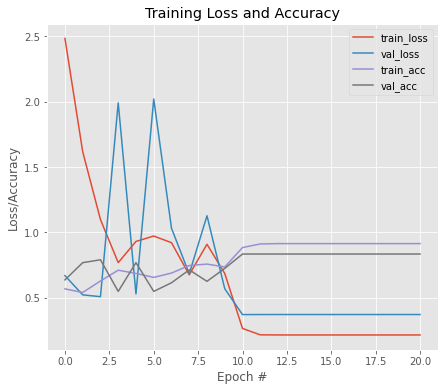


Model Performance Summary:

Best Validation accuracy:0.8351648449897766 at EPOCH:11
3/3 [==============================] - 0s 93ms/step
Accuracy: 0.8351648351648352
Sensitivity: 0.7804878048780488
AUC:0.8302439024390245


,Model,Accuracy,Precision,Recall,F1,AUC,Sensitivity,Specificity,Kappa
0,RIM-ONE_v2_A_False_0.2_vgg16,0.835165,0.842105,0.780488,0.810127,0.830244,0.780488,0.88,0.664866


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 32768)             0         
                                                                 
 dense_3 (Dense)             (None, 2)                 65538     
                                                                 
Total params: 14,780,226
Trainable params: 65,538
Non-trainable params: 14,714,688
_________________________________________________________________
None

Epoch 1: val_accuracy improved from -inf to 0.49451, saving model to vgg16_a.hdf5

Epoch 2: val_accuracy improved from 0.49451 to 0.74725, saving model to vgg16_a.hdf5

Epoch 3: val_accuracy did not improve from 0.74725

Epoch 4: val_accuracy did not improve from 0.74725

Epoch 5: val_accuracy did not

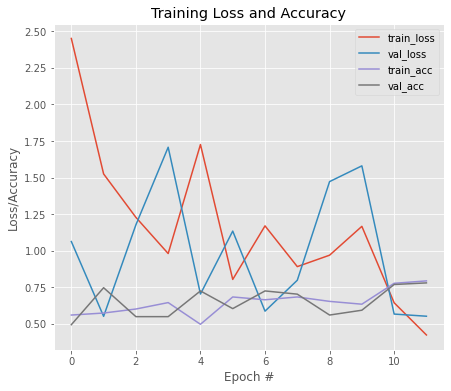


Model Performance Summary:

Best Validation accuracy:0.7802197933197021 at EPOCH:12
3/3 [==============================] - 0s 92ms/step
Accuracy: 0.7802197802197802
Sensitivity: 0.6585365853658537
AUC:0.769268292682927


,Model,Accuracy,Precision,Recall,F1,AUC,Sensitivity,Specificity,Kappa
0,RIM-ONE_v2_A_True_0.2_vgg16,0.78022,0.818182,0.658537,0.72973,0.769268,0.658537,0.88,0.548163


80150528/80134624 [==============================] - 0s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 8, 8, 512)         20024384  
                                                                 
 flatten_4 (Flatten)         (None, 32768)             0         
                                                                 
 dense_4 (Dense)             (None, 2)                 65538     
                                                                 
Total params: 20,089,922
Trainable params: 65,538
Non-trainable params: 20,024,384
_________________________________________________________________
None

Epoch 1: val_accuracy improved from -inf to 0.54945, saving model to vgg19_a.hdf5

Epoch 2: val_accuracy improved from 0.54945 to 0.70330, saving model to vgg19_a.hdf5

Epoch 3: val_accuracy improved from 0.70330 to 0.73626, saving model

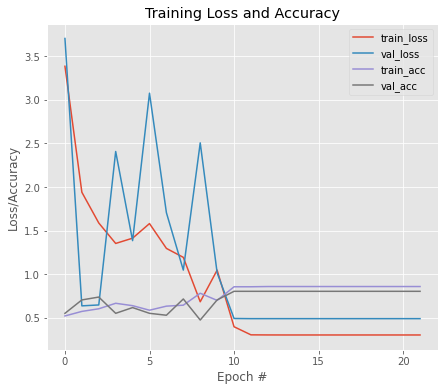


Model Performance Summary:

Best Validation accuracy:0.8021978139877319 at EPOCH:11
3/3 [==============================] - 0s 108ms/step
Accuracy: 0.8021978021978022
Sensitivity: 0.7073170731707317
AUC:0.7936585365853659


,Model,Accuracy,Precision,Recall,F1,AUC,Sensitivity,Specificity,Kappa
0,RIM-ONE_v2_A_False_0.2_vgg19,0.802198,0.828571,0.707317,0.763158,0.793659,0.707317,0.88,0.595156


Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 8, 8, 512)         20024384  
                                                                 
 flatten_5 (Flatten)         (None, 32768)             0         
                                                                 
 dense_5 (Dense)             (None, 2)                 65538     
                                                                 
Total params: 20,089,922
Trainable params: 65,538
Non-trainable params: 20,024,384
_________________________________________________________________
None

Epoch 1: val_accuracy improved from -inf to 0.45055, saving model to vgg19_a.hdf5

Epoch 2: val_accuracy improved from 0.45055 to 0.72527, saving model to vgg19_a.hdf5

Epoch 3: val_accuracy did not improve from 0.72527

Epoch 4: val_accuracy did not improve from 0.72527

Epoch 5: val_accuracy did not

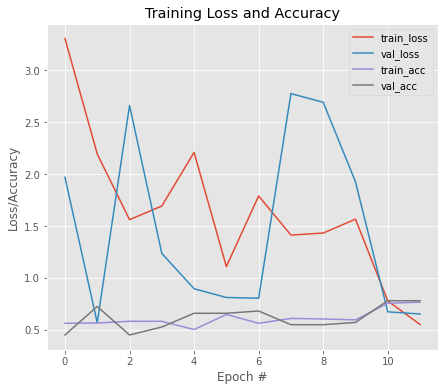


Model Performance Summary:

Best Validation accuracy:0.7802197933197021 at EPOCH:11
3/3 [==============================] - 0s 108ms/step
Accuracy: 0.7802197802197802
Sensitivity: 0.6585365853658537
AUC:0.769268292682927


,Model,Accuracy,Precision,Recall,F1,AUC,Sensitivity,Specificity,Kappa
0,RIM-ONE_v2_A_True_0.2_vgg19,0.78022,0.818182,0.658537,0.72973,0.769268,0.658537,0.88,0.548163


94781440/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 flatten_6 (Flatten)         (None, 131072)            0         
                                                                 
 dense_6 (Dense)             (None, 2)                 262146    
                                                                 
Total params: 23,849,858
Trainable params: 262,146
Non-trainable params: 23,587,712
_________________________________________________________________
None

Epoch 1: val_accuracy improved from -inf to 0.54945, saving model to resnet50_a.hdf5

Epoch 2: val_accuracy did not improve from 0.54945

Epoch 3: val_accuracy did not improve from 0.54945

Epoch 4: val_accuracy did not improve from 

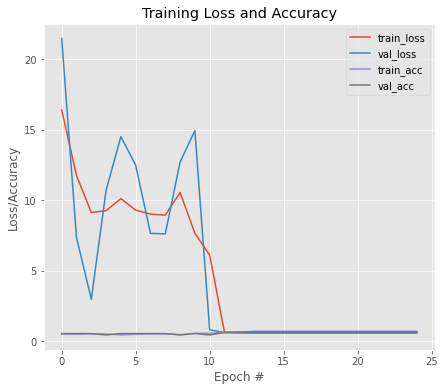


Model Performance Summary:

Best Validation accuracy:0.6813187003135681 at EPOCH:14
3/3 [==============================] - 1s 65ms/step
Accuracy: 0.6813186813186813
Sensitivity: 0.3170731707317073
AUC:0.6485365853658537


,Model,Accuracy,Precision,Recall,F1,AUC,Sensitivity,Specificity,Kappa
0,RIM-ONE_v2_A_False_0.2_resnet50,0.681319,0.928571,0.317073,0.472727,0.648537,0.317073,0.98,0.315789


Model: "resnet50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 flatten_7 (Flatten)         (None, 131072)            0         
                                                                 
 dense_7 (Dense)             (None, 2)                 262146    
                                                                 
Total params: 23,849,858
Trainable params: 262,146
Non-trainable params: 23,587,712
_________________________________________________________________
None

Epoch 1: val_accuracy improved from -inf to 0.54945, saving model to resnet50_a.hdf5

Epoch 2: val_accuracy did not improve from 0.54945

Epoch 3: val_accuracy did not improve from 0.54945

Epoch 4: val_accuracy did not improve from 0.54945

Epoch 5: val_accuracy did not improve from 0.54945

Epoc

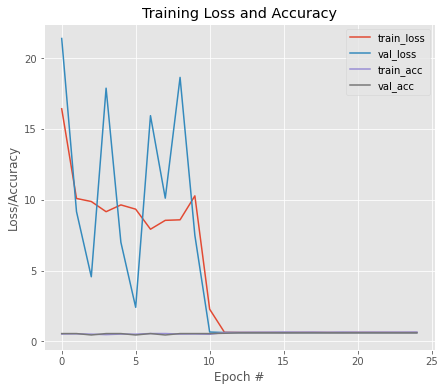


Model Performance Summary:

Best Validation accuracy:0.6043956279754639 at EPOCH:13
3/3 [==============================] - 1s 66ms/step
Accuracy: 0.6043956043956044
Sensitivity: 0.12195121951219512
AUC:0.5609756097560976


,Model,Accuracy,Precision,Recall,F1,AUC,Sensitivity,Specificity,Kappa
0,RIM-ONE_v2_A_True_0.2_resnet50,0.604396,1.0,0.121951,0.217391,0.560976,0.121951,1.0,0.132415


29097984/29084464 [==============================] - 0s 0us/step
Model: "DenseNet121"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 8, 8, 1024)        7037504   
                                                                 
 flatten_8 (Flatten)         (None, 65536)             0         
                                                                 
 dense_8 (Dense)             (None, 2)                 131074    
                                                                 
Total params: 7,168,578
Trainable params: 131,074
Non-trainable params: 7,037,504
_________________________________________________________________
None

Epoch 1: val_accuracy improved from -inf to 0.54945, saving model to DenseNet121_a.hdf5

Epoch 2: val_accuracy improved from 0.54945 to 0.65934, saving model to DenseNet121_a.hdf5

Epoch 3: val_accuracy improved from 0.65934 to 0.81

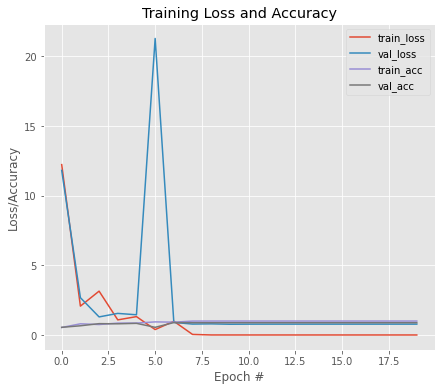


Model Performance Summary:

Best Validation accuracy:0.8901098966598511 at EPOCH:7
3/3 [==============================] - 2s 65ms/step
Accuracy: 0.8901098901098901
Sensitivity: 0.926829268292683
AUC:0.8934146341463415


,Model,Accuracy,Precision,Recall,F1,AUC,Sensitivity,Specificity,Kappa
0,RIM-ONE_v2_A_False_0.2_DenseNet121,0.89011,0.844444,0.926829,0.883721,0.893415,0.926829,0.86,0.779981


Model: "DenseNet121"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 8, 8, 1024)        7037504   
                                                                 
 flatten_9 (Flatten)         (None, 65536)             0         
                                                                 
 dense_9 (Dense)             (None, 2)                 131074    
                                                                 
Total params: 7,168,578
Trainable params: 131,074
Non-trainable params: 7,037,504
_________________________________________________________________
None

Epoch 1: val_accuracy improved from -inf to 0.54945, saving model to DenseNet121_a.hdf5

Epoch 2: val_accuracy improved from 0.54945 to 0.72527, saving model to DenseNet121_a.hdf5

Epoch 3: val_accuracy improved from 0.72527 to 0.78022, saving model to DenseNet121_a.hdf5

Epoch 4: val_accuracy di

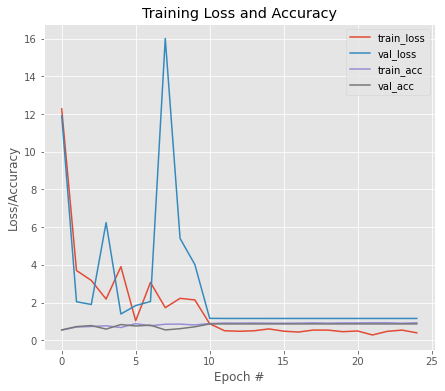


Model Performance Summary:

Best Validation accuracy:0.8681318759918213 at EPOCH:11
3/3 [==============================] - 2s 65ms/step
Accuracy: 0.8681318681318682
Sensitivity: 0.8536585365853658
AUC:0.8668292682926829


,Model,Accuracy,Precision,Recall,F1,AUC,Sensitivity,Specificity,Kappa
0,RIM-ONE_v2_A_True_0.2_DenseNet121,0.868132,0.853659,0.853659,0.853659,0.866829,0.853659,0.88,0.733659


17235968/17225924 [==============================] - 0s 0us/step
Model: "MobileNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 8, 8, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten_10 (Flatten)        (None, 65536)             0         
                                                                 
 dense_10 (Dense)            (None, 2)                 131074    
                                                                 
Total params: 3,359,938
Trainable params: 131,074
Non-trainable params: 3,228,864
_________________________________________________________________
None

Epoch 1: val_accuracy improved from -inf to 0.74725, saving model to MobileNet_a.hdf5

Epoch 2: val_accuracy improved from 0.74725 to 0.89011, saving model to MobileNet

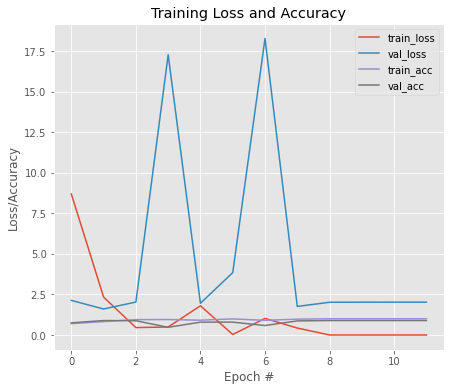


Model Performance Summary:

Best Validation accuracy:0.8901098966598511 at EPOCH:2
3/3 [==============================] - 0s 30ms/step
Accuracy: 0.8901098901098901
Sensitivity: 0.8048780487804879
AUC:0.8824390243902439


,Model,Accuracy,Precision,Recall,F1,AUC,Sensitivity,Specificity,Kappa
0,RIM-ONE_v2_A_False_0.2_MobileNet,0.89011,0.942857,0.804878,0.868421,0.882439,0.804878,0.96,0.775087


Model: "MobileNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 8, 8, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten_11 (Flatten)        (None, 65536)             0         
                                                                 
 dense_11 (Dense)            (None, 2)                 131074    
                                                                 
Total params: 3,359,938
Trainable params: 131,074
Non-trainable params: 3,228,864
_________________________________________________________________
None

Epoch 1: val_accuracy improved from -inf to 0.81319, saving model to MobileNet_a.hdf5

Epoch 2: val_accuracy did not improve from 0.81319

Epoch 3: val_accuracy improved from 0.81319 to 0.86813, saving model to MobileNet_a.hdf5

Epoc

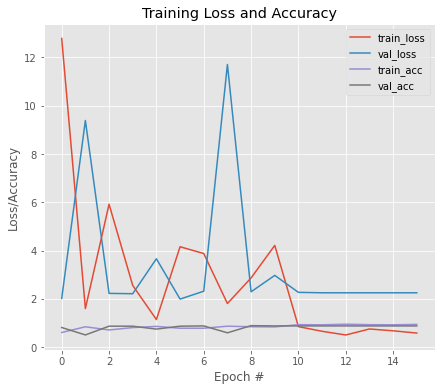


Model Performance Summary:

Best Validation accuracy:0.8901098966598511 at EPOCH:9
3/3 [==============================] - 0s 30ms/step
Accuracy: 0.8901098901098901
Sensitivity: 0.8048780487804879
AUC:0.8824390243902439


,Model,Accuracy,Precision,Recall,F1,AUC,Sensitivity,Specificity,Kappa
0,RIM-ONE_v2_A_True_0.2_MobileNet,0.89011,0.942857,0.804878,0.868421,0.882439,0.804878,0.96,0.775087


9420800/9406464 [==============================] - 0s 0us/step
Model: "MobileNetV2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_12 (Flatten)        (None, 81920)             0         
                                                                 
 dense_12 (Dense)            (None, 2)                 163842    
                                                                 
Total params: 2,421,826
Trainable params: 163,842
Non-trainable params: 2,257,984
_________________________________________________________________
None

Epoch 1: val_accuracy improved from -inf to 0.83516, saving model to MobileNetV2_a.hdf5

Epoch 2: val_accuracy improved from 0.83516 to 0.86813, saving model to MobileN

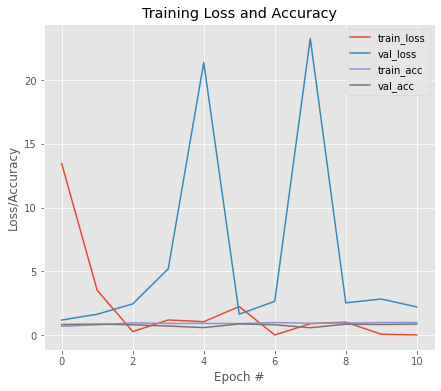


Model Performance Summary:

Best Validation accuracy:0.8791208863258362 at EPOCH:6
3/3 [==============================] - 1s 33ms/step
Accuracy: 0.8791208791208791
Sensitivity: 0.9024390243902439
AUC:0.881219512195122


,Model,Accuracy,Precision,Recall,F1,AUC,Sensitivity,Specificity,Kappa
0,RIM-ONE_v2_A_False_0.2_MobileNetV2,0.879121,0.840909,0.902439,0.870588,0.88122,0.902439,0.86,0.757451


Model: "MobileNetV2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_13 (Flatten)        (None, 81920)             0         
                                                                 
 dense_13 (Dense)            (None, 2)                 163842    
                                                                 
Total params: 2,421,826
Trainable params: 163,842
Non-trainable params: 2,257,984
_________________________________________________________________
None

Epoch 1: val_accuracy improved from -inf to 0.78022, saving model to MobileNetV2_a.hdf5

Epoch 2: val_accuracy improved from 0.78022 to 0.84615, saving model to MobileNetV2_a.hdf5

Epoch 3: val_accuracy did not improve from 0.84615

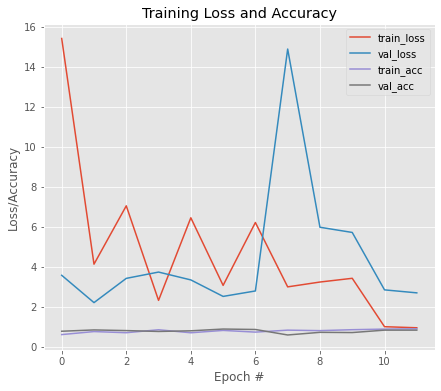


Model Performance Summary:

Best Validation accuracy:0.8901098966598511 at EPOCH:6
3/3 [==============================] - 1s 33ms/step
Accuracy: 0.8901098901098901
Sensitivity: 0.8536585365853658
AUC:0.8868292682926829


,Model,Accuracy,Precision,Recall,F1,AUC,Sensitivity,Specificity,Kappa
0,RIM-ONE_v2_A_True_0.2_MobileNetV2,0.89011,0.897436,0.853659,0.875,0.886829,0.853659,0.92,0.77707


87924736/87910968 [==============================] - 0s 0us/step
Model: "InceptionV3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 flatten_14 (Flatten)        (None, 73728)             0         
                                                                 
 dense_14 (Dense)            (None, 2)                 147458    
                                                                 
Total params: 21,950,242
Trainable params: 147,458
Non-trainable params: 21,802,784
_________________________________________________________________
None

Epoch 1: val_accuracy improved from -inf to 0.54945, saving model to InceptionV3_a.hdf5

Epoch 2: val_accuracy improved from 0.54945 to 0.82418, saving model to InceptionV3_a.hdf5

Epoch 3: val_accuracy did not improve from 0.8241

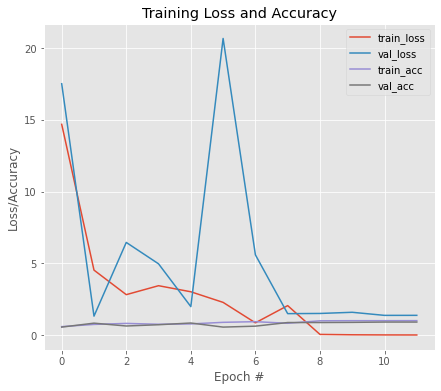


Model Performance Summary:

Best Validation accuracy:0.901098906993866 at EPOCH:11
3/3 [==============================] - 1s 55ms/step
Accuracy: 0.9010989010989011
Sensitivity: 0.8536585365853658
AUC:0.8968292682926828


,Model,Accuracy,Precision,Recall,F1,AUC,Sensitivity,Specificity,Kappa
0,RIM-ONE_v2_A_False_0.2_InceptionV3,0.901099,0.921053,0.853659,0.886076,0.896829,0.853659,0.94,0.79892


Model: "InceptionV3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 flatten_15 (Flatten)        (None, 73728)             0         
                                                                 
 dense_15 (Dense)            (None, 2)                 147458    
                                                                 
Total params: 21,950,242
Trainable params: 147,458
Non-trainable params: 21,802,784
_________________________________________________________________
None

Epoch 1: val_accuracy improved from -inf to 0.74725, saving model to InceptionV3_a.hdf5

Epoch 2: val_accuracy did not improve from 0.74725

Epoch 3: val_accuracy did not improve from 0.74725

Epoch 4: val_accuracy did not improve from 0.74725

Epoch 5: val_accuracy improved from 0.74725 to 0.8

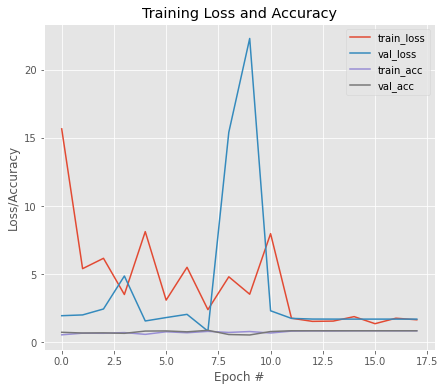


Model Performance Summary:

Best Validation accuracy:0.8901098966598511 at EPOCH:8
3/3 [==============================] - 1s 54ms/step
Accuracy: 0.8901098901098901
Sensitivity: 0.926829268292683
AUC:0.8934146341463415


,Model,Accuracy,Precision,Recall,F1,AUC,Sensitivity,Specificity,Kappa
0,RIM-ONE_v2_A_True_0.2_InceptionV3,0.89011,0.844444,0.926829,0.883721,0.893415,0.926829,0.86,0.779981


219070464/219055592 [==============================] - 1s 0us/step
Model: "InceptionResNetV2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 6, 6, 1536)       54336736  
 onal)                                                           
                                                                 
 flatten_16 (Flatten)        (None, 55296)             0         
                                                                 
 dense_16 (Dense)            (None, 2)                 110594    
                                                                 
Total params: 54,447,330
Trainable params: 110,594
Non-trainable params: 54,336,736
_________________________________________________________________
None

Epoch 1: val_accuracy improved from -inf to 0.67033, saving model to InceptionResNetV2_a.hdf5

Epoch 2: val_accuracy did not improve from 0.67033

Epoch 3: 

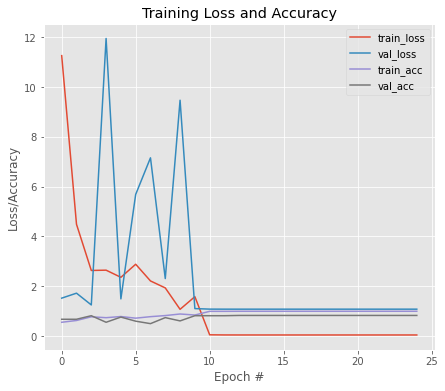


Model Performance Summary:

Best Validation accuracy:0.8241758346557617 at EPOCH:13
3/3 [==============================] - 3s 133ms/step
Accuracy: 0.8241758241758241
Sensitivity: 0.7804878048780488
AUC:0.8202439024390245


,Model,Accuracy,Precision,Recall,F1,AUC,Sensitivity,Specificity,Kappa
0,RIM-ONE_v2_A_False_0.2_InceptionResNetV2,0.824176,0.820513,0.780488,0.8,0.820244,0.780488,0.86,0.643312


Model: "InceptionResNetV2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 6, 6, 1536)       54336736  
 onal)                                                           
                                                                 
 flatten_17 (Flatten)        (None, 55296)             0         
                                                                 
 dense_17 (Dense)            (None, 2)                 110594    
                                                                 
Total params: 54,447,330
Trainable params: 110,594
Non-trainable params: 54,336,736
_________________________________________________________________
None

Epoch 1: val_accuracy improved from -inf to 0.72527, saving model to InceptionResNetV2_a.hdf5

Epoch 2: val_accuracy did not improve from 0.72527

Epoch 3: val_accuracy did not improve from 0.72527

Epoch 4: val_accuracy di

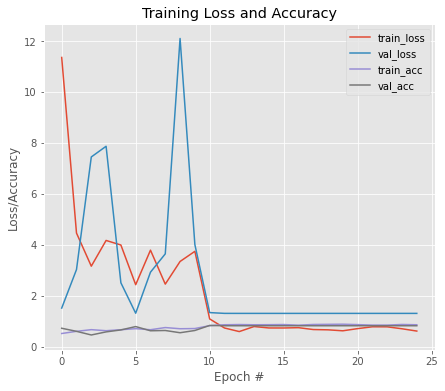


Model Performance Summary:

Best Validation accuracy:0.8351648449897766 at EPOCH:11
3/3 [==============================] - 3s 133ms/step
Accuracy: 0.8351648351648352
Sensitivity: 0.7804878048780488
AUC:0.8302439024390245


,Model,Accuracy,Precision,Recall,F1,AUC,Sensitivity,Specificity,Kappa
0,RIM-ONE_v2_A_True_0.2_InceptionResNetV2,0.835165,0.842105,0.780488,0.810127,0.830244,0.780488,0.88,0.664866


83697664/83683744 [==============================] - 1s 0us/step
Model: "xception"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 flatten_18 (Flatten)        (None, 131072)            0         
                                                                 
 dense_18 (Dense)            (None, 2)                 262146    
                                                                 
Total params: 21,123,626
Trainable params: 262,146
Non-trainable params: 20,861,480
_________________________________________________________________
None

Epoch 1: val_accuracy improved from -inf to 0.64835, saving model to xception_a.hdf5

Epoch 2: val_accuracy improved from 0.64835 to 0.81319, saving model to xception_a.hdf5

Epoch 3: val_accuracy improved from 0.81319 to 0.82418, sa

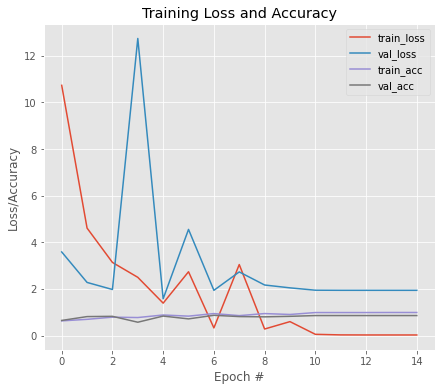


Model Performance Summary:

Best Validation accuracy:0.8681318759918213 at EPOCH:7
3/3 [==============================] - 1s 93ms/step
Accuracy: 0.8681318681318682
Sensitivity: 0.7804878048780488
AUC:0.8602439024390244


,Model,Accuracy,Precision,Recall,F1,AUC,Sensitivity,Specificity,Kappa
0,RIM-ONE_v2_A_False_0.2_xception,0.868132,0.914286,0.780488,0.842105,0.860244,0.780488,0.94,0.730104


Model: "xception"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 flatten_19 (Flatten)        (None, 131072)            0         
                                                                 
 dense_19 (Dense)            (None, 2)                 262146    
                                                                 
Total params: 21,123,626
Trainable params: 262,146
Non-trainable params: 20,861,480
_________________________________________________________________
None

Epoch 1: val_accuracy improved from -inf to 0.71429, saving model to xception_a.hdf5

Epoch 2: val_accuracy did not improve from 0.71429

Epoch 3: val_accuracy improved from 0.71429 to 0.75824, saving model to xception_a.hdf5

Epoch 4: val_accuracy did not improve from 0.75824

Epoch 5: val_accura

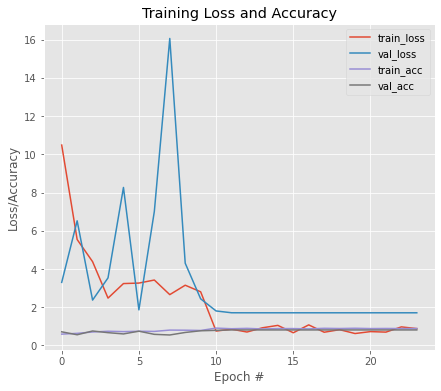


Model Performance Summary:

Best Validation accuracy:0.8131868243217468 at EPOCH:12
3/3 [==============================] - 1s 93ms/step
Accuracy: 0.8131868131868132
Sensitivity: 0.7073170731707317
AUC:0.8036585365853659


,Model,Accuracy,Precision,Recall,F1,AUC,Sensitivity,Specificity,Kappa
0,RIM-ONE_v2_A_True_0.2_xception,0.813187,0.852941,0.707317,0.773333,0.803659,0.707317,0.9,0.616795


In [ ]:
data_aug = [False,True]
split_ratio = [0.2]
for model in MODEL_LIST:
   for aug in data_aug:
      model_obj = HIGH_LEVEL_MODEL(model,inputshape=(256,256,3))
      name = f"RIM-ONE_v2_A_{aug}_0.2_{model}"
      model_obj.train_phase(trainx,trainy,testx,testy,data_aug=aug, model_name = name)

,Model,Accuracy,Precision,Recall,F1,AUC,Sensitivity,Specificity,kappa
0,RIM-ONE_v2_A_False_0.2_vgg16,0.835165,0.842105,0.780488,0.810127,0.830244,0.780488,0.88,0.664866
1,RIM-ONE_v2_A_True_0.2_vgg16,0.780220,0.818182,0.658537,0.729730,0.769268,0.658537,0.88,0.548163
2,RIM-ONE_v2_A_False_0.2_vgg19,0.802198,0.828571,0.707317,0.763158,0.793659,0.707317,0.88,0.595156
3,RIM-ONE_v2_A_True_0.2_vgg19,0.780220,0.818182,0.658537,0.729730,0.769268,0.658537,0.88,0.548163
4,RIM-ONE_v2_A_False_0.2_resnet50,0.681319,0.928571,0.317073,0.472727,0.648537,0.317073,0.98,0.315789
5,RIM-ONE_v2_A_True_0.2_resnet50,0.604396,1.000000,0.121951,0.217391,0.560976,0.121951,1.00,0.132415
6,RIM-ONE_v2_A_False_0.2_DenseNet121,0.890110,0.844444,0.926829,0.883721,0.893415,0.926829,0.86,0.779981
7,RIM-ONE_v2_A_True_0.2_DenseNet121,0.868132,0.853659,0.853659,0.853659,0.866829,0.853659,0.88,0.733659
8,RIM-ONE_v2_A_False_0.2_MobileNet,0.890110,0.942857,0.804878,0.868421,0.882439,0.804878,0.96,0.775087
9,RIM-ONE_v2_A_True_0.2_MobileNet,0.890110,0.942857,0.804878,0.868421,0.882439,0.804878,0.96,0.775087


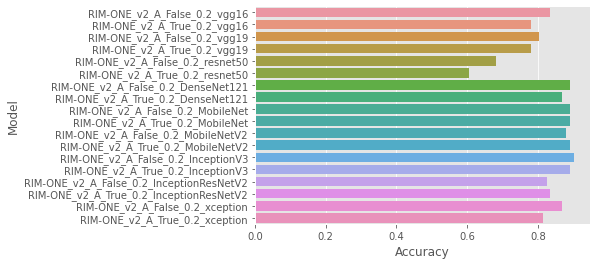

\begin{tabular}{lrrrrrrrr}
\toprule
                                   Model &  Accuracy &  Precision &   Recall &       F1 &      AUC &  Sensitivity &  Specificity &    kappa \\
\midrule
            RIM-ONE\_v2\_A\_False\_0.2\_vgg16 &  0.835165 &   0.842105 & 0.780488 & 0.810127 & 0.830244 &     0.780488 &         0.88 & 0.664866 \\
             RIM-ONE\_v2\_A\_True\_0.2\_vgg16 &  0.780220 &   0.818182 & 0.658537 & 0.729730 & 0.769268 &     0.658537 &         0.88 & 0.548163 \\
            RIM-ONE\_v2\_A\_False\_0.2\_vgg19 &  0.802198 &   0.828571 & 0.707317 & 0.763158 & 0.793659 &     0.707317 &         0.88 & 0.595156 \\
             RIM-ONE\_v2\_A\_True\_0.2\_vgg19 &  0.780220 &   0.818182 & 0.658537 & 0.729730 & 0.769268 &     0.658537 &         0.88 & 0.548163 \\
         RIM-ONE\_v2\_A\_False\_0.2\_resnet50 &  0.681319 &   0.928571 & 0.317073 & 0.472727 & 0.648537 &     0.317073 &         0.98 & 0.315789 \\
          RIM-ONE\_v2\_A\_True\_0.2\_resnet50 &  0.604396 &   1.000000 &

In [ ]:
plot_performance()